In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import sparse
from tqdm.notebook import tqdm

%matplotlib inline

# Сырые данные

## Считываем данные из .csv

Некоторые данные (такие как рубрики и признаки), представлены строками значений. Преобразуем их в списки чисел. 

In [3]:
to_list = lambda rubrics: [int(rubric) for rubric in str(rubrics).split(' ')]
def apply_to_columns(df, columns, func=to_list):
    for column in columns:
        df.loc[~df[column].isnull(), column] = df.loc[~df[column].isnull(), column].apply(func)

В первую очередь нам понадобятся данные по __пользователям__, __организациям__ и сами __отзывы__. 

In [4]:
users = pd.read_csv('users.csv')
users.head()

,user_id,city
0,523295021912509756,msk
1,11952159487361099606,msk
2,16879036589969590999,msk
3,12791716990148606332,msk
4,11642393216024958726,msk


In [5]:
users['user_id'].astype('str')

0            523295021912509756
1          11952159487361099606
2          16879036589969590999
3          12791716990148606332
4          11642393216024958726
                   ...         
1252796     4041285221021488584
1252797     5513108081655150498
1252798    10646870695977399500
1252799     5822981410234667999
1252800     3263863687260387202
Name: user_id, Length: 1252801, dtype: object

In [6]:
orgs = pd.read_csv('organisations.csv')

# create lists
columns = ['rubrics_id', 'features_id']
apply_to_columns(orgs, columns)

orgs.head()

,org_id,city,average_bill,rating,rubrics_id,features_id
0,16848414477362211020,spb,1000.0,4.479702,"[30776, 31375]","[1018, 1509, 11177, 11617, 11629, 11704, 11867..."
1,1430604733320164116,spb,1000.0,4.514509,"[30776, 30770]","[246, 1018, 11617, 11629, 11704, 11867, 20422,..."
2,9880309324224147401,spb,1000.0,3.884615,"[30770, 30774]","[1018, 11177, 11617, 11629, 11704, 11867, 2042..."
3,5617879987171966456,spb,1000.0,NaN,"[30774, 30775]","[1018, 1509, 10596, 11177, 11629, 11634, 11704..."
4,5241461680470612149,spb,1000.0,4.532468,[30776],"[1018, 11177, 11617, 11629, 11704, 11867, 2042..."


Чтобы не делать __join__ каждый раз, когда нам потребуется узнать, из какого города организация или пользователь, сразу добавим эту информацию в отзывы.

In [7]:
reviews = pd.read_csv('reviews.csv', low_memory=False)

# encode users ids as numeric
reviews = reviews.merge(users, on='user_id')
reviews = reviews.rename({'city': 'user_city'}, axis=1)

# # encode orgs ids as numeric
reviews = reviews.merge(orgs[['org_id', 'city']], on='org_id')
reviews = reviews.rename({'city': 'org_city'}, axis=1)

# # create lists
columns = ['aspects']
apply_to_columns(reviews, columns)

reviews.head()

,user_id,org_id,rating,ts,aspects,user_city,org_city
0,16998268288908323644,7184895086928047809,2.0,105,NaN,msk,msk
1,3121447338909258868,7184895086928047809,5.0,464,NaN,msk,msk
2,1970649778250883025,7184895086928047809,3.0,789,NaN,msk,msk
3,7554889464530643866,7184895086928047809,4.0,936,NaN,msk,msk
4,15907910894057053620,7184895086928047809,1.0,1143,NaN,msk,msk


Отлично, теперь с отзывами будет удобно работать. 

Посмотрим на распределение новых отзывов по дням, чтобы понять, как лучше организовать валидацию. 

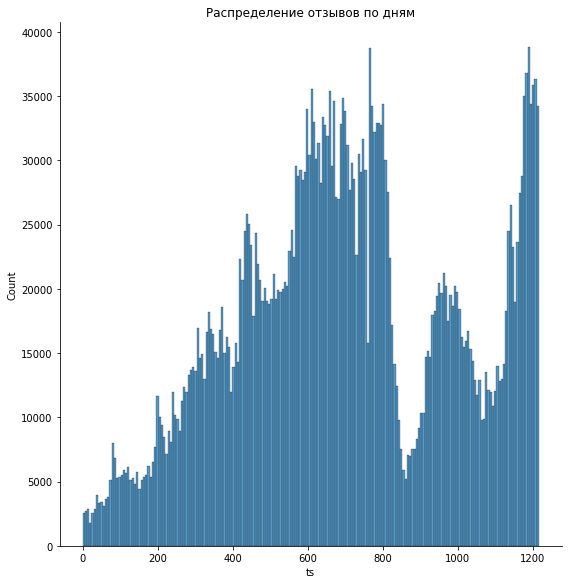

In [8]:
sns.displot(data=reviews, x='ts', height=8)
plt.title('Распределение отзывов по дням')
plt.show()

# Train-test split

In [10]:
def clear_df(df, suffixes=['_x', '_y'], inplace=True):
    '''
    clear_df(df, suffixes=['_x', '_y'], inplace=True)
        Удаляет из входного df все колонки, оканчивающиеся на заданные суффиксы. 
        
        Parameters
        ----------
        df : pandas.DataFrame
        
        suffixies : Iterable, default=['_x', '_y']
            Суффиксы колонок, подлежащих удалению
            
        inplace : bool, default=True
            Нужно ли удалить колонки "на месте" или же создать копию DataFrame.
            
        Returns
        -------
        pandas.DataFrame (optional)
            df с удалёнными колонками
    '''
    
    def bad_suffix(column):
        nonlocal suffixes
        return any(column.endswith(suffix) for suffix in suffixes)
        
    columns_to_drop = [col for col in df.columns if bad_suffix(col)]
    return df.drop(columns_to_drop, axis=1, inplace=inplace)


def extract_unique(reviews, column): 
    '''
    extract_unique(reviews, column)
        Извлекает уникальные значения из колонки в DataFrame.
        
        Parameters
        ----------
        reviews : pandas.DataFrame
            pandas.DataFrame, из которого будут извлечены значения.
        
        column : str
            Имя колонки в <reviews>.
        
        Returns
        -------
        pandas.DataFrame
            Содержит одну именованную колонку с уникальными значениями. 
    '''
    
    unique = reviews[column].unique()
    return pd.DataFrame({column: unique})


def count_unique(reviews, column):
    '''
    count_unique(reviews, column)
        Извлекает и подсчитывает уникальные значения из колонки в DataFrame.
        
        Parameters
        ----------
        reviews : pandas.DataFrame
            pandas.DataFrame, из которого будут извлечены значения.
        
        column : str
            Имя колонки в <reviews>.
        
        Returns
        -------
        pandas.DataFrame
            Содержит две колонки: с уникальными значениями и счётчиком встреченных. 
    '''
    
    return reviews[column].value_counts().reset_index(name='count').rename({'index': column}, axis=1)



def filter_reviews(reviews, users=None, orgs=None): 
    '''
    filter_reviews(reviews, users=None, orgs=None)
    Оставляет в выборке только отзывы, оставленные заданными пользователями на заданные организации. 
    
    Parameters
    ----------
        users: pandas.DataFrame, default=None
            DataFrame, содержащий колонку <user_id>.
            Если None, то фильтрация не происходит. 
            
        orgs: pandas.DataFrame, default=None
            DataFrame, содержащий колонку <org_id>.
            Если None, то фильтрация не происходит. 
    
    Returns
    -------
        pandas.DataFrame
            Отфильтрованная выборка отзывов. 

    '''
    if users is not None: 
        reviews = reviews.merge(users, on='user_id', how='inner')
        clear_df(reviews)
        
    if orgs is not None:
        reviews = reviews.merge(orgs, on='org_id', how='inner')
        clear_df(reviews)
        
    return reviews


def train_test_split(reviews, ts_start, ts_end=None):
    '''
    train_test_split(reviews, ts_start, ts_end=None)
        Разделяет выборку отзывов на две части: обучающую и тестовую. 
        В тестовую выборку попадают только отзывы с user_id и org_id, встречающимися в обучающей выборке.

        Parameters
        ----------
        reviews : pandas.DataFrame 
            Отзывы из reviews.csv с обязательными полями:
                <rating>, <ts>, <user_id>, <user_city>, <org_id>, <org_city>.

        ts_start : int
            Первый день отзывов из тестовой выборки (включительно).

        ts_end : int, default=None
            Последний день отзывов из обучающей выборки (включительно)
            Если параметр равен None, то ts_end == reviews['ts'].max(). 

        Returns
        -------
        splitting : tuple
            Кортеж из двух pandas.DataFrame такой же структуры, как и reviews:
            в первом отзывы, попавшие в обучающую выборку, во втором - в тестовую.
    '''
    
    if not ts_end:
        ts_end = reviews['ts'].max()
    
    
    reviews_train = reviews[(reviews['ts'] < ts_start) | (reviews['ts'] > ts_end)]
    reviews_test = reviews[(ts_start <= reviews['ts']) & (reviews['ts'] <= ts_end)]
    
    # 1. Выбираем только отзывы на понравившиеся места у путешественников
    reviews_test = reviews_test[reviews_test['rating'] >= 4.0]
    reviews_test = reviews_test[reviews_test['user_city'] != reviews_test['org_city']]
    
    # 2. Оставляем в тесте только тех пользователей и организации, которые встречались в трейне
    train_orgs = extract_unique(reviews_train, 'org_id')
    train_users = extract_unique(reviews_train, 'user_id')
    
    reviews_test = filter_reviews(reviews_test, orgs=train_orgs)

    return reviews_train, reviews_test


def process_reviews(reviews):
    '''
    process_reviews(reviews)
        Извлекает из набора отзывов тестовых пользователей и таргет. 
        
        Parameters
        ----------
        reviews : pandas.DataFrame
            DataFrame с отзывами, содержащий колонки <user_id> и <org_id>
        
        Returns
        -------
        X : pandas.DataFrame
            DataFrame такой же структуры, как и в test_users.csv
            
        y : pandas.DataFrame
            DataFrame с колонками <user_id> и <target>. 
            В <target> содержится список org_id, посещённых пользователем. 
    '''
    
    y = reviews.groupby('user_id')['org_id'].apply(list).reset_index(name='target')
    X = pd.DataFrame(y['user_id'])
    
    return X, y

In [11]:
reviews['ts'].max()

1216

Всего в выборку попали отызывы за **1216** дней. 

Отложим в тестовую выборку отзывы за последние **100** дней.

In [12]:
train_reviews, test_reviews = train_test_split(reviews, 1116)
X_test, y_test = process_reviews(test_reviews)

In [18]:
y_test

,user_id,target
0,2183246479913987,[496392304596904549]
1,2296072303631704,[8639952498359513722]
2,2734551237953758,[16792714808333152673]
3,3127332141603176,[17666062872958735246]
4,8312342049993844,[3510190647522788742]
...,...,...
12039,18442659241319947115,[3182217017434418454]
12040,18443831757209556307,[12254870161467238503]
12041,18444191212623472278,[14057304744096609518]
12042,18444723476913326916,[17760854033094560270]


Посмотрим, сколько всего уникальных пользователей попало в эту тестовую выборку:

In [19]:
len(X_test)

12044

# Метрика

Метрика принимает на вход два DataFrame, имеющих такую же структуру, как и **y_test**.

`print_score` домножает реальное значение метрики на 100 так же, как и в контесте.

Подобная имплементация используется для оценки **submission**.

In [33]:
def MNAP(size=20):
    '''
    MNAP(size=20)
        Создаёт метрику под <size> сделанных предсказаний.
        
        Parameters
        ----------
        size : int, default=20
            Размер рекомендованной выборки для каждого пользователя
        
        Returns
        -------
        func(pd.DataFrame, pd.DataFrame) -> float
            Функция, вычисляющая MNAP.
        
    '''
    
    assert size >= 1, "Size must be greater than zero!"
    
    def metric(y_true, predictions, size=size):
        '''
        metric(y_true, predictions, size=size)
            Метрика MNAP для двух перемешанных наборов <y_true> и <y_pred>.
            
            Parameters
            ----------
            y_true : pd.DataFrame
                DataFrame с колонками <user_id> и <target>. 
                В <target> содержится список настоящих org_id, посещённых пользователем. 
                
            predictions : pd.DataFrame
                DataFrame с колонками <user_id> и <target>. 
                В <target> содержится список рекомендованных для пользователя org_id.
                
            Returns
            -------
            float 
                Значение метрики.
        '''
        
        y_true = y_true.rename({'target': 'y_true'}, axis='columns')
        predictions = predictions.rename({'target': 'predictions'}, axis='columns')
        
        merged = y_true.merge(predictions, left_on='user_id', right_on='user_id')
    
        def score(x, size=size):
            '''
            Вспомогательная функция.
            '''
            
            
            y_true = x[1].y_true
            predictions = x[1].predictions[:size]

            
            weight = 0
            
            inner_weights = [0]
            for n, item in enumerate(predictions):
                inner_weight = inner_weights[-1] + (1 if item in y_true else 0)
                inner_weights.append(inner_weight)
            
            for n, item in enumerate(predictions):                
                if item in y_true:
                    weight += inner_weights[n + 1] / (n + 1)
                    
            return weight / min(len(y_true), size)
    
        return np.mean([score(row) for row in merged.iterrows()])
    
        
    return metric


def print_score(score):
    print(f"Score: {score*100.0:.2f}")
    
    
N = 20
MNAP_N = MNAP(N)

# Подходы без машинного обучения

## Случайные N мест

Попробуем предлагать пользователям случайные места из другого города. 

In [25]:
spb_orgs = orgs[orgs['city'] == 'spb']['org_id']
msk_orgs = orgs[orgs['city'] == 'msk']['org_id']

test_users_with_locations = X_test.merge(users, on='user_id')

In [34]:
%%time

np.random.seed(1337)
choose = lambda x: np.random.choice(spb_orgs, N) if x['city'] == 'msk' else np.random.choice(msk_orgs, N)
target = test_users_with_locations.apply(choose, axis=1)

predictions = X_test.copy()
predictions['target'] = target

print_score(MNAP_N(y_test, predictions))

Score: 0.02
CPU times: user 4.06 s, sys: 7.33 ms, total: 4.07 s
Wall time: 4.04 s


## N самых популярных мест

Предыдущий подход, очевидно, не очень удачно предсказывает, какие места посетит пользователей. 

Попробуем улучшить стратегию: будем предлагать пользователям самые популярные места, то есть те, на которые оставлено больше всего отзывов. 

In [14]:
msk_orgs = train_reviews[(train_reviews['rating'] >= 4) & (train_reviews['org_city'] == 'msk')]['org_id']
msk_orgs = msk_orgs.value_counts().index[:N].to_list()

spb_orgs = train_reviews[(train_reviews['rating'] >= 4) & (train_reviews['org_city'] == 'spb')]['org_id']
spb_orgs = spb_orgs.value_counts().index[:N].to_list()

In [15]:
%%time

choose = lambda x: spb_orgs if x['city'] == 'msk' else msk_orgs
target = test_users_with_locations.apply(choose, axis=1)

predictions = X_test.copy()
predictions['target'] = target

print_score(MNAP_N(y_test, predictions))

Score: 4.21
CPU times: user 637 ms, sys: 9.89 ms, total: 647 ms
Wall time: 647 ms


Отлично, метрика немного улучшилась. Но стоит попробовать доработать эту тактику. 

## N самых популярных мест среди туристов

In [16]:
tourist_reviews = train_reviews[train_reviews['rating'] >= 4.0]

# набор отзывов только от туристов
tourist_reviews = tourist_reviews[tourist_reviews['user_city'] != tourist_reviews['org_city']]

# выбираем самые популярные места среди туристов из Москвы и Питера
msk_orgs = tourist_reviews[tourist_reviews['org_city'] == 'msk']['org_id']
msk_orgs = msk_orgs.value_counts().index[:N].to_list()

spb_orgs = tourist_reviews[tourist_reviews['org_city'] == 'spb']['org_id']
spb_orgs = spb_orgs.value_counts().index[:N].to_list()

In [17]:
%%time

choose = lambda x: spb_orgs if x['city'] == 'msk' else msk_orgs
target = test_users_with_locations.apply(choose, axis=1)

predictions = X_test.copy()
predictions['target'] = target

print_score(MNAP_N(y_test, predictions))

Score: 6.40
CPU times: user 652 ms, sys: 5.35 ms, total: 657 ms
Wall time: 657 ms


Метрика улучшилась ещё немного.

## N / rubrics_count самых популярных мест из каждой рубрики

In [18]:
def extract_top_by_rubrics(reviews, N):
    '''
    extract_top_by_rubrics(reviews, N)
        Набирает самые популярные организации по рубрикам, сохраняя распределение.
        
        Parameters
        ----------
        reviews : pd.DataFrame
            Отзывы пользователей для рекомендации.
            
        N : int
            Число рекомендаций.
        
        Returns
        -------
        orgs_list : list
            Список отобранных организаций.
    '''
    
    # извлечение популярных рубрик
    reviews = reviews.merge(orgs, on='org_id')[['org_id', 'rubrics_id']]
    
    rubrics = reviews.explode('rubrics_id').groupby('rubrics_id').size()
    rubrics = (rubrics / rubrics.sum() * N).apply(round).sort_values(ascending=False)

    # вывод списка рубрик по убыванию популярности
#     print(
#         pd.read_csv('data/rubrics.csv')
#         .merge(rubrics.reset_index(), left_index=True, right_on='rubrics_id')
#         .sort_values(by=0, ascending=False)[['rubric_id', 0]]
#     )
    
    # извлечение популярных организаций
    train_orgs = reviews.groupby('org_id').size().reset_index(name='count').merge(orgs, on='org_id')
    train_orgs = train_orgs[['org_id', 'count', 'rubrics_id']]

    most_popular_rubric = lambda rubrics_id: max(rubrics_id, key=lambda rubric_id: rubrics[rubric_id])
    train_orgs['rubrics_id'] = train_orgs['rubrics_id'].apply(most_popular_rubric)
    
    orgs_by_rubrics = train_orgs.sort_values(by='count', ascending=False).groupby('rubrics_id')['org_id'].apply(list)
    
    # соберём самые популярные организации в рубриках в один список
    
    orgs_list = []

    for rubric_id, count in zip(rubrics.index, rubrics):
        if rubric_id not in orgs_by_rubrics:
            continue 

        orgs_list.extend(orgs_by_rubrics[rubric_id][:count])
    
    return orgs_list


msk_orgs = extract_top_by_rubrics(tourist_reviews[tourist_reviews['org_city'] == 'msk'], N)
spb_orgs = extract_top_by_rubrics(tourist_reviews[tourist_reviews['org_city'] == 'spb'], N)

In [19]:
%%time

choose = lambda x: spb_orgs if x['city'] == 'msk' else msk_orgs
target = test_users_with_locations.apply(choose, axis=1)

predictions = X_test.copy()
predictions['target'] = target

print_score(MNAP_N(y_test, predictions))

Score: 5.77
CPU times: user 642 ms, sys: 5 ms, total: 647 ms
Wall time: 647 ms


# Время ML! Коллаборативная фильтрация

## Memory-based

Для этой группы методов требуется явное построение матрицы __пользователь-организация__ (__interaction matrix__), где на пересечении $i$-ой строки и $j$-ого столбца будет рейтинг, который $i$-ый пользователь выставил $j$-ой организации или же пропуск, если рейтинг не был установлен. 

In [20]:
def reduce_reviews(reviews, min_user_reviews=5, min_org_reviews=13):
    '''
    reduce_reviews(reviews, min_user_reviews=5, min_org_reviews=13)
        Убирает из выборки пользователей и организации, у которых менее <min_reviews> отзывов в родном городе. 
        Оставляет только отзывы туристов. 
        
        Parameters
        ----------
        reviews : pandas.DataFrame 
            Выборка отзывов с обязательными полями:
                <user_id>, <user_city>.
        
        min_user_reviews : int, default=5
            Минимальное количество отзывов у пользователя, необходимое для включения в выборку.
            
        min_org_reviews : int, default=13
            Минимальное количество отзывов у организации, необходимое для включения в выборку.
            
        Returns
        -------
        splitting : tuple
            Кортеж из двух наборов.
            Каждый набор содержит 2 pandas.DataFrame:
                1. Урезанная выборка отзывов
                2. Набор уникальных организаций
                
            Первый набор содержит DataFrame-ы, относящиеся к отзывам, оставленным в родном городе, а второй -
            к отзывам, оставленным в чужом городе. ё
            
        users : pd.DataFrame
            Набор уникальных пользователей в выборке
        
    '''
    
    inner_reviews = reviews[reviews['user_city'] == reviews['org_city']]
    outer_reviews = reviews[reviews['user_city'] != reviews['org_city']]

    # оставляем только отзывы туристов на родной город 
    tourist_users = extract_unique(outer_reviews, 'user_id')
    inner_reviews = filter_reviews(inner_reviews, users=tourist_users)
    
    # выбираем только тех пользователей и организации, у которых есть <min_reviews> отзывов
    top_users = count_unique(inner_reviews, 'user_id')
    top_users = top_users[top_users['count'] >= min_user_reviews]
        
    top_orgs = count_unique(inner_reviews, 'org_id')
    top_orgs = top_orgs[top_orgs['count'] >= min_org_reviews]
        
    inner_reviews = filter_reviews(inner_reviews, users=top_users, orgs=top_orgs)
    outer_reviews = filter_reviews(outer_reviews, users=top_users)
    
    # combine reviews
    reviews = pd.concat([inner_reviews, outer_reviews])
    users = extract_unique(reviews, 'user_id')
    orgs = extract_unique(reviews, 'org_id')
    
    
    return (
        (
            inner_reviews,
            extract_unique(inner_reviews, 'org_id')
        ),
        (
            outer_reviews,
            extract_unique(outer_reviews, 'org_id')
        ),
        extract_unique(inner_reviews, 'user_id')
    )

In [21]:
def create_mappings(df, column):
    '''
    create_mappings(df, column)
        Создаёт маппинг между оригинальными ключами словаря и новыми порядковыми.
        
        Parameters
        ----------
        df : pandas.DataFrame
            DataFrame с данными.
            
        column : str
            Название колонки, содержащей нужны ключи. 
        
        Returns
        -------
        code_to_idx : dict
            Словарь с маппингом: "оригинальный ключ" -> "новый ключ".
        
        idx_to_code : dict
            Словарь с маппингом: "новый ключ" -> "оригинальный ключ".
    '''
    
    code_to_idx = {}
    idx_to_code = {}
    
    for idx, code in enumerate(df[column].to_list()):
        code_to_idx[code] = idx
        idx_to_code[idx] = code
        
    return code_to_idx, idx_to_code


def map_ids(row, mapping):
    '''
    Вспомогательная функция
    '''
    
    return mapping[row]


def interaction_matrix(reviews, test_users, min_user_reviews=5, min_org_reviews=12): 
    '''
    interaction_matrix(reviews, test_users, min_user_reviews=5, min_org_reviews=12)
        Создаёт блочную матрицу взаимодействий (вид матрицы описан в Returns)
        
        Parameters
        ----------
        reviews : pd.DataFrame
            Отзывы пользователей для матрицы взаимодействий.
            
        test_users : pd.DataFrame
            Пользователи, для которых будет выполнятся предсказание. 
        
        min_user_reviews : int, default=5
            Минимальное число отзывов от пользователя, необходимое для включения его в матрицу.
        
        min_org_reviews : int, default=12
            Минимальное число отзывов на организацию, необходимое для включения её в матрицу.
    
        Returns
        -------
        InteractionMatrix : scipy.sparse.csr_matrix
            Матрица, содержащая рейтинги, выставленные пользователями.
            Она блочная и имеет такой вид:
                 ---------------------------------------------------
                | TRAIN USERS, INNER ORGS | TRAIN USERS, OUTER ORGS |
                |                         |                         |
                 ---------------------------------------------------
                |  TEST USERS, INNER ORGS |  TEST USERS, OUTER ORGS |
                |                         |                         |
                 ---------------------------------------------------

        splitting : tuple
            Кортеж, содержащий два целых числа: 
                1. Число пользователей в обучающей выборке 
                2. Число организаций в домашнем регионе

        splitting: tuple
            Кортеж, содержащий два котрежа из двух словарей:
                1. (idx_to_uid, uid_to_idx) - содержит маппинг индекса к user_id
                2. (idx_to_oid, oid_to_idx) - содержит маппинг индекса к org_id
    '''
    
    
    info = reduce_reviews(train_reviews, min_user_reviews, min_org_reviews)
    (inner_reviews, inner_orgs), (outer_reviews, outer_orgs), train_users = info
    
    # удалим из обучающей выборки пользователей, которые есть в тестовой
    test_users = test_users[['user_id']]
    
    train_users = (
        pd.merge(train_users, test_users, indicator=True, how='outer')
        .query('_merge=="left_only"')
        .drop('_merge', axis=1)
    )
    
    inner_reviews = filter_reviews(inner_reviews, train_users)
    outer_reviews = filter_reviews(outer_reviews, train_users)
    
    # оставляем отзывы, оставленные тестовыми пользователями
    test_reviews = filter_reviews(reviews, test_users, pd.concat([inner_orgs, outer_orgs]))
    
    # получаем полный набор маппингов
    all_users = pd.concat([train_users, test_users])
    all_orgs = pd.concat([inner_orgs, outer_orgs])
    
    uid_to_idx, idx_to_uid = create_mappings(all_users, 'user_id')
    oid_to_idx, idx_to_oid = create_mappings(all_orgs, 'org_id')
    
    # собираем матрицу взаимодействий 
    reviews = pd.concat([inner_reviews, outer_reviews, test_reviews])    
        
    I = reviews['user_id'].apply(map_ids, args=[uid_to_idx]).values
    J = reviews['org_id'].apply(map_ids, args=[oid_to_idx]).values
    values = reviews['rating']
        
    interactions = sparse.coo_matrix(
        (values, (I, J)), 
        shape=(len(all_users), len(all_orgs)), 
        dtype=np.float64
    ).tocsr()
    
    
    return (
        interactions, 
        (len(train_users), len(inner_orgs)), 
        (
            (idx_to_uid, uid_to_idx),
            (idx_to_oid, oid_to_idx)
        )
    )

## ALS

In [22]:
%%time


import implicit


def make_predictions(interactions, X_test, N):
    '''
    make_predictions(interactions, X_test, N)
        Делает рекомендации для пользователей из <X_test> на основе матрицы взаимодействий. 
        
        Parameters
        ----------
        interactions : scipy.sparse.csr_matrix
            Разреженная матрица взаимодействий.
            
        X_test : pd.DataFrame
            Набор тестовых пользователей, для которых нужно сделать рекомендации. 
        
        N : int
            Число рекомендаций для каждого пользователя. 
        
        Returns
        -------
        predictions : pd.DataFrame
            DataFrame с колонками <user_id> и <target>. 
            В <target> содержится список рекомендованных для пользователя org_id.
        
        
    '''
    
    predictions = X_test[['user_id']].copy()
    predictions['target'] = pd.Series(dtype=object)
    predictions = predictions.set_index('user_id')
    
    interactions, (train_users_len, inner_orgs_len), mappings = interactions
    (idx_to_uid, uid_to_idx), (idx_to_oid, oid_to_idx) = mappings

    base_model = implicit.als.AlternatingLeastSquares(
        factors=5, 
        iterations=75, 
        regularization=0.05, 
        random_state=42
    )
    
    base_model.fit(interactions.T)
    
    orgs_to_filter = list(np.arange(inner_orgs_len))

    recommendations = base_model.recommend_all(
        interactions,
        N=N,
        filter_already_liked_items=True,
        filter_items=orgs_to_filter,
        show_progress=True
    )
    
    for user_id in tqdm(X_test['user_id'].values, leave=False):
        predictions.loc[user_id, 'target'] = list(
            map(
                lambda org_idx: idx_to_oid[org_idx], 
                recommendations[uid_to_idx[user_id]]
            )
        )
        
    return predictions.reset_index()


msk_interactions = interaction_matrix(
    train_reviews[train_reviews['user_city'] == 'msk'],
    test_users_with_locations[test_users_with_locations['city'] == 'msk'],
)

spb_interactions = interaction_matrix(
    train_reviews[train_reviews['user_city'] == 'spb'],
    test_users_with_locations[test_users_with_locations['city'] == 'spb'],
)       
        
test_msk_users = test_users_with_locations[test_users_with_locations['city'] == 'msk']
test_spb_users = test_users_with_locations[test_users_with_locations['city'] == 'spb']

msk_predictions = make_predictions(msk_interactions, test_msk_users, N)
spb_predictions = make_predictions(spb_interactions, test_spb_users, N)

predictions = pd.concat([msk_predictions, spb_predictions])

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/32242 [00:00<?, ?it/s]

  0%|          | 0/9545 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/25789 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

CPU times: user 1min 52s, sys: 1.97 s, total: 1min 54s
Wall time: 34.6 s


In [23]:
%%time

print_score(MNAP_N(y_test, predictions))

Score: 0.85
CPU times: user 592 ms, sys: 12.3 ms, total: 604 ms
Wall time: 607 ms


# Submission

Выберем лучший метод на валидации, переобучим его на всей выборке и сделаем предсказание на тестовой выборке. 

## Without ML

In [24]:
# набор отзывов только от туристов
tourist_reviews = reviews[reviews['rating'] >= 4.0]
tourist_reviews = tourist_reviews[tourist_reviews['user_city'] != tourist_reviews['org_city']]

# выбираем самые популярные места среди туристов из Москвы и Питера
msk_orgs = tourist_reviews[tourist_reviews['org_city'] == 'msk']['org_id']
msk_orgs = msk_orgs.value_counts().index[:N].to_list()

spb_orgs = tourist_reviews[tourist_reviews['org_city'] == 'spb']['org_id']
spb_orgs = spb_orgs.value_counts().index[:N].to_list()


msk_orgs = str(' '.join(map(str, msk_orgs)))
spb_orgs = str(' '.join(map(str, spb_orgs)))

In [25]:
test_users = pd.read_csv('data/test_users.csv')
test_users['city'] = test_users.merge(users, on='user_id')['city']

In [26]:
choose = lambda x: spb_orgs if x['city'] == 'msk' else msk_orgs
target = test_users.apply(choose, axis=1)

predictions = test_users[['user_id']]
predictions['target'] = target

predictions.head()

,user_id,target
0,3545210947248911048,12046097390037935713 5002407858008059043 14814...
1,15271987121288045390,12046097390037935713 5002407858008059043 14814...
2,15016858616184265932,12046097390037935713 5002407858008059043 14814...
3,12457244142928722989,12046097390037935713 5002407858008059043 14814...
4,13339684649926251468,15250345250621165867 13573322486152844808 9104...


In [27]:
predictions.to_csv('answers.csv', index=None)

## With ML

In [28]:
test_users = pd.read_csv('data/test_users.csv')
test_users = test_users.merge(users, on='user_id')


test_msk_users = test_users[test_users['city'] == 'msk'][['user_id', 'city']]
test_spb_users = test_users[test_users['city'] == 'spb'][['user_id', 'city']]


msk_interactions = interaction_matrix(
    reviews[reviews['user_city'] == 'msk'],
    test_msk_users
)

spb_interactions = interaction_matrix(
    reviews[reviews['user_city'] == 'spb'],
    test_spb_users
)

msk_predictions = make_predictions(msk_interactions, test_msk_users, N)
spb_predictions = make_predictions(spb_interactions, test_spb_users, N)

predictions = pd.concat([msk_predictions, spb_predictions])

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/36615 [00:00<?, ?it/s]

  0%|          | 0/14638 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/25547 [00:00<?, ?it/s]

  0%|          | 0/2329 [00:00<?, ?it/s]

In [29]:
predictions['target'] = predictions['target'].apply(lambda orgs: ' '.join(map(str, orgs)))
predictions.head()

,user_id,target
0,3545210947248911048,10899892390879739444 6556420723466820988 12320...
1,15271987121288045390,6755179149394338096 4264897535035612511 133612...
2,15016858616184265932,7034326954454250932 14180000520266438941 12018...
3,12457244142928722989,7034326954454250932 15250345250621165867 12018...
4,16511650156158419042,10899892390879739444 1232005279283743070 15250...


In [30]:
predictions.to_csv('answers_ml.csv', index=None)